# Notebook 05 - Modelling and Evaluation

## Objectives

* Fit and evaluate a classification model that predicts whether or not an existing customer will default in the following month

## Inputs

* Data Cleaning pipeline
* Feature Engineering pipeline

## Outputs

* Combined data cleaning and feature engineering pipeline
* Pipeline for modelling and hyperparameter optimisation
* [xxx]

## Additional Comments

* We already have separate pipelines for data cleaning and feature engineering. However, for ease of use on future datasets, these can be combined into a single pipeline

---

# Change working directory

* This notebook is stored in the `jupyter_notebooks` subfolder
* The current working directory therefore needs to be changed to the workspace, i.e., the working directory needs to be changed from the current folder to its parent folder

Firstly, the current directory is accessed with os.getcwd()

In [52]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\franc\\credit-card-default'

Next, the working directory is set as the parent of the current `jupyter_notebooks` directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory
* This allows access to all the files and folders within the workspace, rather than solely those within the `jupyter_notebooks` directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Finally, confirm that the new current directory has been successfully set

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\franc\\credit-card-default'

---

# Load data

The data is loaded from the outputs/datasets/collection folder:

In [58]:
import pandas as pd
df = pd.read_csv('outputs/datasets/collection/credit_card_data.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


---

# ML pipeline for data cleaning and feature engineering

Here our existing data cleaning and feature engineering pipelines are combined into a single pipeline:

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from feature_engine.selection import DropFeatures
from feature_engine.encoding import OneHotEncoder


def rename_columns(X):
    X.columns = ['credit_limit', 'sex', 'education', 'marital_status',
                 'age', 'late_sep', 'late_aug', 'late_jul', 'late_jun',
                 'late_may', 'late_apr', 'bill_sep', 'bill_aug',
                 'bill_jul', 'bill_jun', 'bill_may', 'bill_apr',
                 'prev_payment_sep', 'prev_payment_aug',
                 'prev_payment_jul', 'prev_payment_jun',
                 'prev_payment_may', 'prev_payment_apr',
                 'default_next_month']
    return X


def clean_categorical_data(X):
    sex_mapping = {1: "male", 2: "female"}
    education_mapping = {1: "graduate school", 2: "university", 3: "high school", 4: "other", 5: "unknown", 6: "unknown"}
    marital_status_mapping = {0: "unknown", 1: "married", 2: "single", 3: "other"}
    X['sex'] = X['sex'].replace(sex_mapping)
    X['education'] = X['education'].replace(education_mapping)
    X['marital_status'] = X['marital_status'].replace(marital_status_mapping)
    return X


def default_summary(X):
    X['any_default'] = X[['late_sep', 'late_aug', 'late_jul', 'late_jun',
                 'late_may', 'late_apr']].gt(0).any(axis=1).astype(int)
    X['total_default'] = X[['late_sep', 'late_aug', 'late_jul', 'late_jun',
                 'late_may', 'late_apr']].clip(lower=0).sum(axis=1)
    X['greatest_default'] = X[['late_sep', 'late_aug', 'late_jul', 'late_jun',
                 'late_may', 'late_apr']].clip(lower=0).max(axis=1)
    return X


def ordinal_encode_education(X):
    X['education'] = X['education'].map(education_map)
    X['education'] = X['education'].fillna(0)
    return X

variables_ohe = ['sex', 'marital_status']

education_map = {
    '0': 0,
    'other': 0,
    'unknown': 0,
    'high school': 1,
    'university': 2,
    'graduate school': 3
}

data_cleaning_and_feature_engineering_pipeline = Pipeline([
      ('drop',  DropFeatures(features_to_drop=['ID'])),
      ('rename_columns', FunctionTransformer(rename_columns, validate=False)),
      ('clean_categorical_data', FunctionTransformer(clean_categorical_data)),
      ('add_default_summary', FunctionTransformer(default_summary)),
      ('one_hot_encode', OneHotEncoder(variables=variables_ohe, drop_last=True)),
      ('ordinal_encode', FunctionTransformer(ordinal_encode_education)),
      ('drop_after_cleaning',  DropFeatures(features_to_drop=['late_sep', 'late_aug', 'late_jun',
                                               'late_may', 'late_apr', 'bill_aug', 
                                               'bill_jul', 'bill_jun', 'bill_may', 
                                               'bill_apr', 'any_default', 'greatest_default',
                                               'marital_status_married'])),
])

---

# ML Pipeline for Modelling and Hyperparameter Optimisation

In [60]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

Custom Class for Hyperparameter Optimisation, taken from CI's WP02:

In [61]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches


---

# Prepare Data for Modelling

## Apply data cleaning and feature engineering pipeline

Since the feature engineering processes for this dataset cannot introduce any bias or data leakage, it is possible (and requires less code) to apply the data cleaning and feature engineering pipeline to the entire dataframe before splitting it into test and train sets:

In [62]:
df = data_cleaning_and_feature_engineering_pipeline.fit_transform(df)
df.head()

,credit_limit,education,age,late_jul,bill_sep,prev_payment_sep,prev_payment_aug,prev_payment_jul,prev_payment_jun,prev_payment_may,prev_payment_apr,default_next_month,total_default,sex_female,marital_status_single,marital_status_other
0,20000.0,2.0,24,-1,3913.0,0.0,689.0,0.0,0.0,0.0,0.0,1,4,1,0,0
1,120000.0,2.0,26,0,2682.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,4,1,1,0
2,90000.0,2.0,34,0,29239.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,0,1,1,0
3,50000.0,2.0,37,0,46990.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,0,1,0,0
4,50000.0,2.0,57,-1,8617.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,0,0,0,0


## Split data into train and test set

Split train and test set. Note that by keeping `random_state` the same value as in the previous notebook, we can be sure to split the data in exactly the same way.
* We inspect the shape of each of `X_train`, `y_train`, `X_test` and `y_test` as a check that the split has worked correctly

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['default_next_month'], axis=1),
    df['default_next_month'],
    test_size=0.2,
    random_state=42,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(24000, 15) (24000,) (6000, 15) (6000,)


In [64]:
y_train.head()

21753    0
251      0
22941    0
618      0
17090    0
Name: default_next_month, dtype: int64

## Handle Target Imbalance

First, we check the distribution of the train set target:

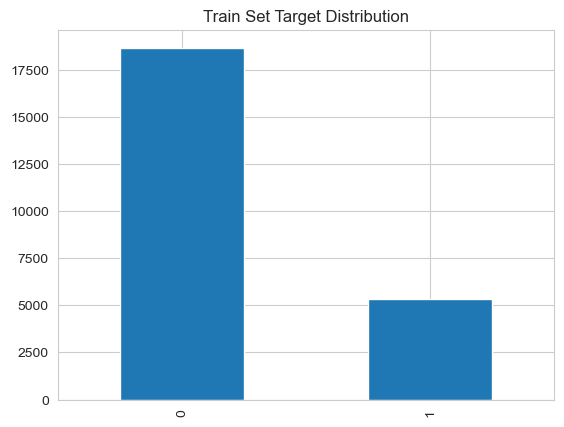

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

We can clearly see that the dataset is imbalanced. To address this, we can either:
* oversample the minority examples to create synthetic examples of the minority class, or
* undersample the majority examples to remove some of the observations that fall into that class.

Both oversampling and undersampling have advantages and disadvantages:
* Oversampling does not decrease the size of the dataset and does not lose any of the information present in the dataset. However, it can increase the chance of overfitting the model, since it increases the presence of characteristics in the dataset that were initially only applicable to a relatively small number of observations
* Undersampling has the advantage that it does not introduce further information into the dataset and create this risk of overfitting. However, it does reduce the size of the dataset and by definition will lose some information.

In this case, the size of the dataset is not excessive and so we will attempt oversampling; however, if we observe that the model is overfitting, we can try undersampling instead.

### Use SMOTE to balance the Train Set target

In [67]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(37354, 15) (37354,) (6000, 15) (6000,)


Finally, we check the train set target distribution again after oversampling:

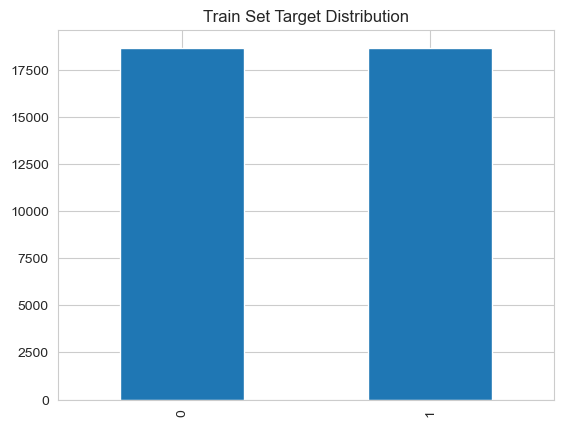

In [68]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
